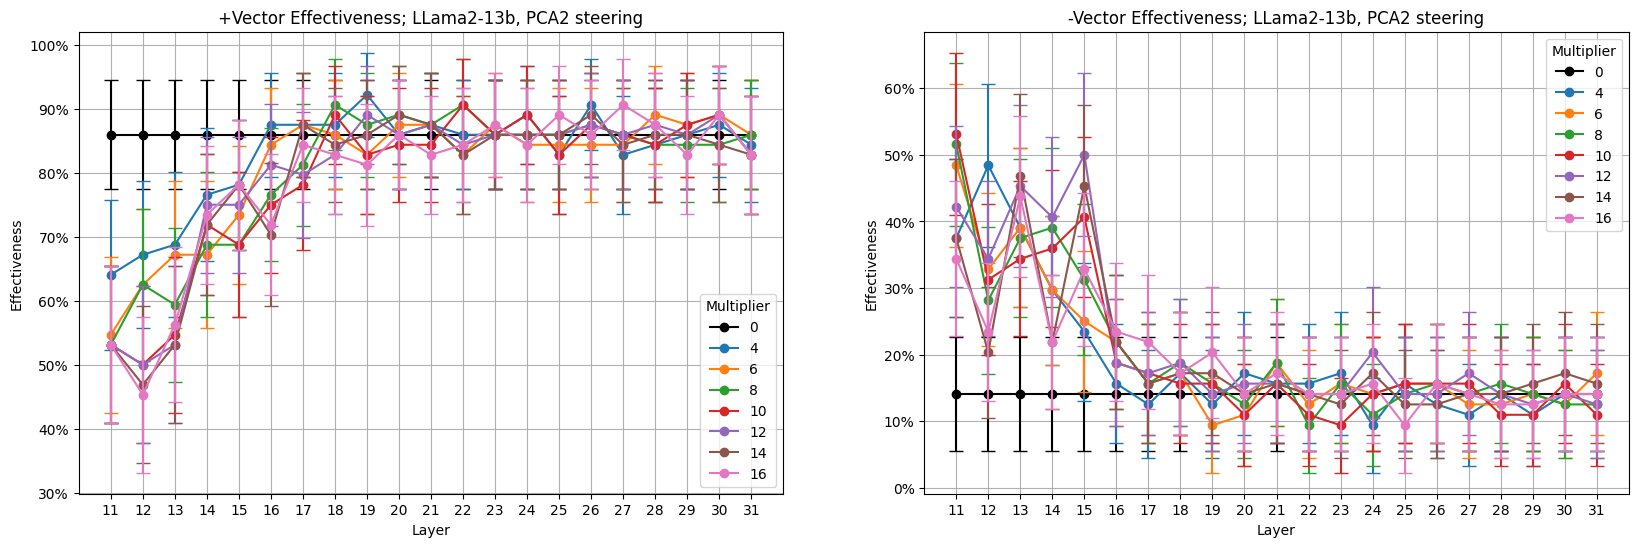

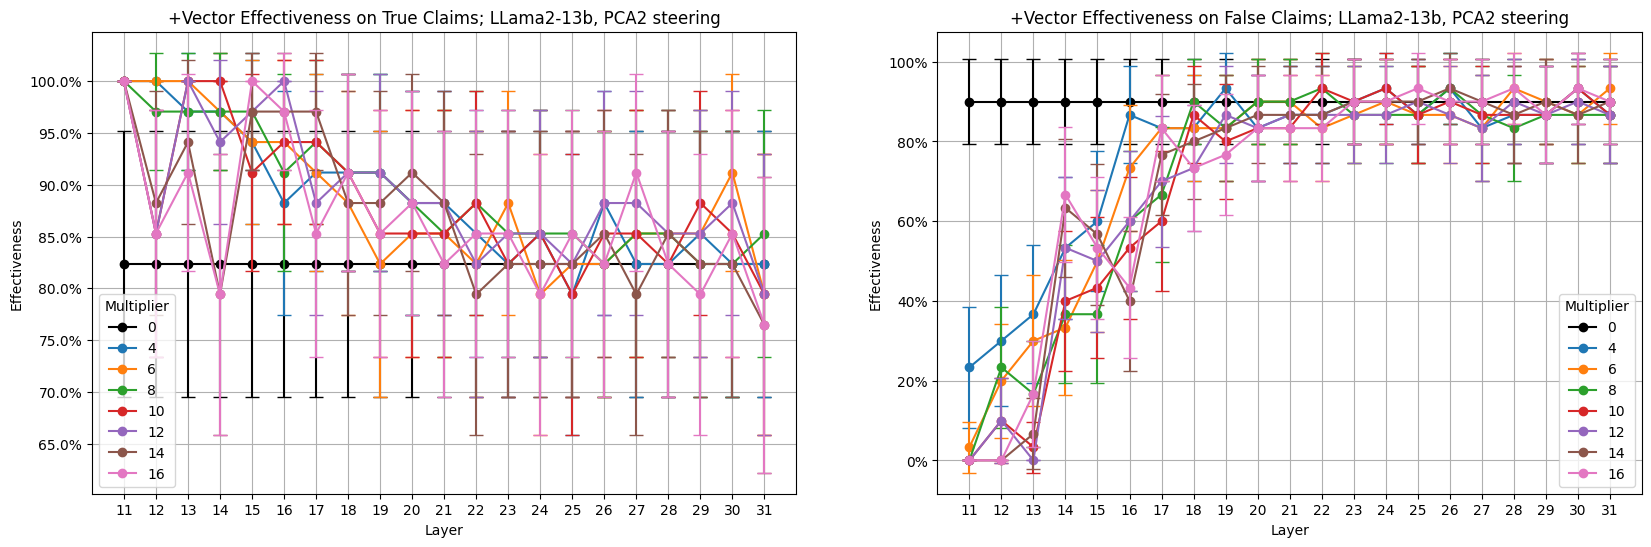

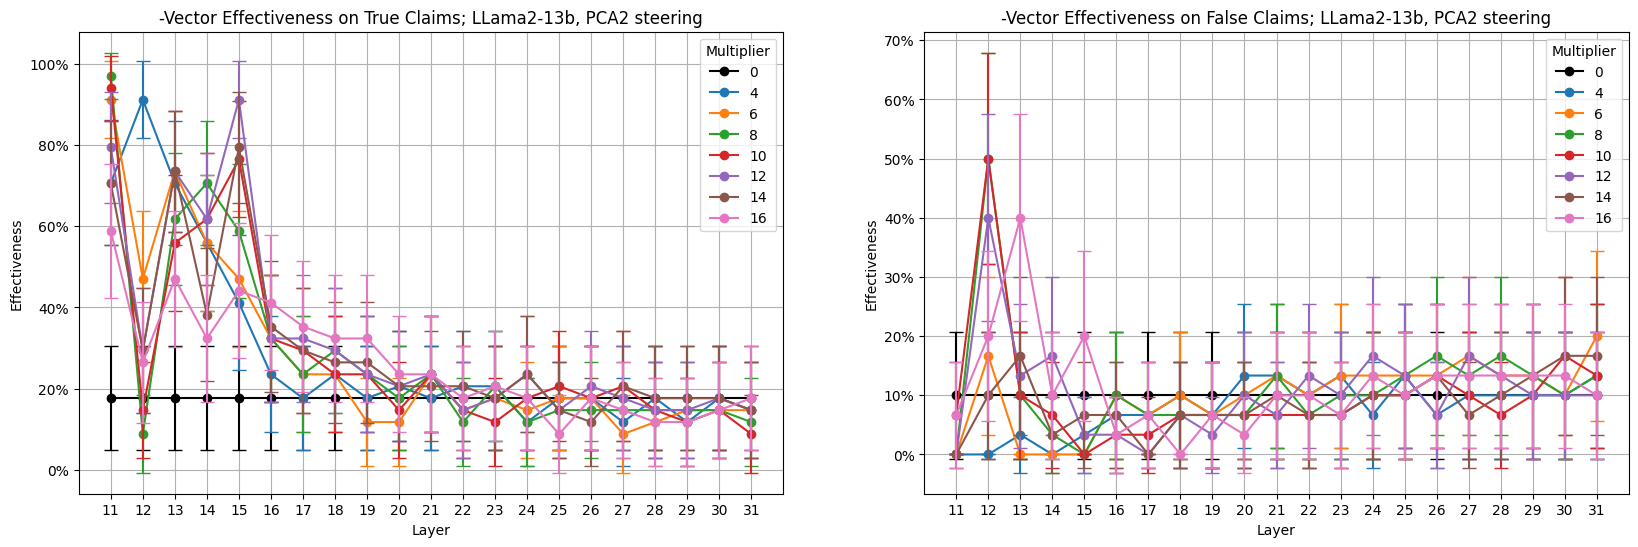

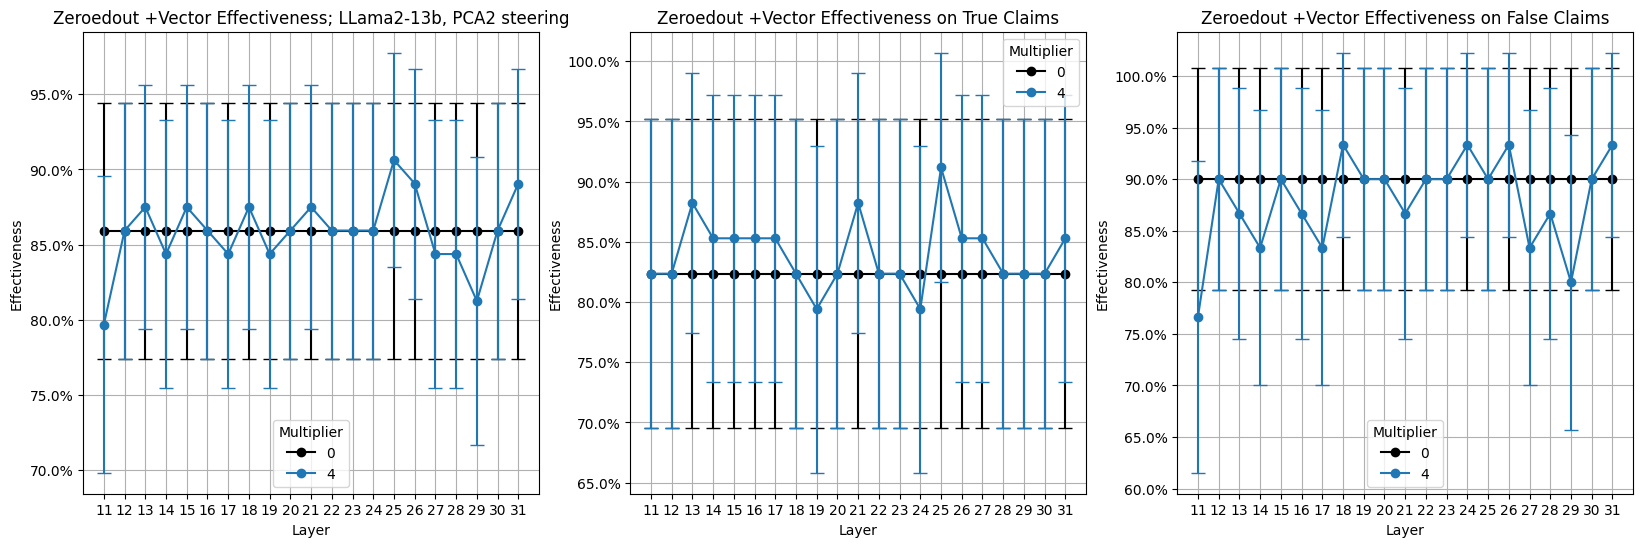

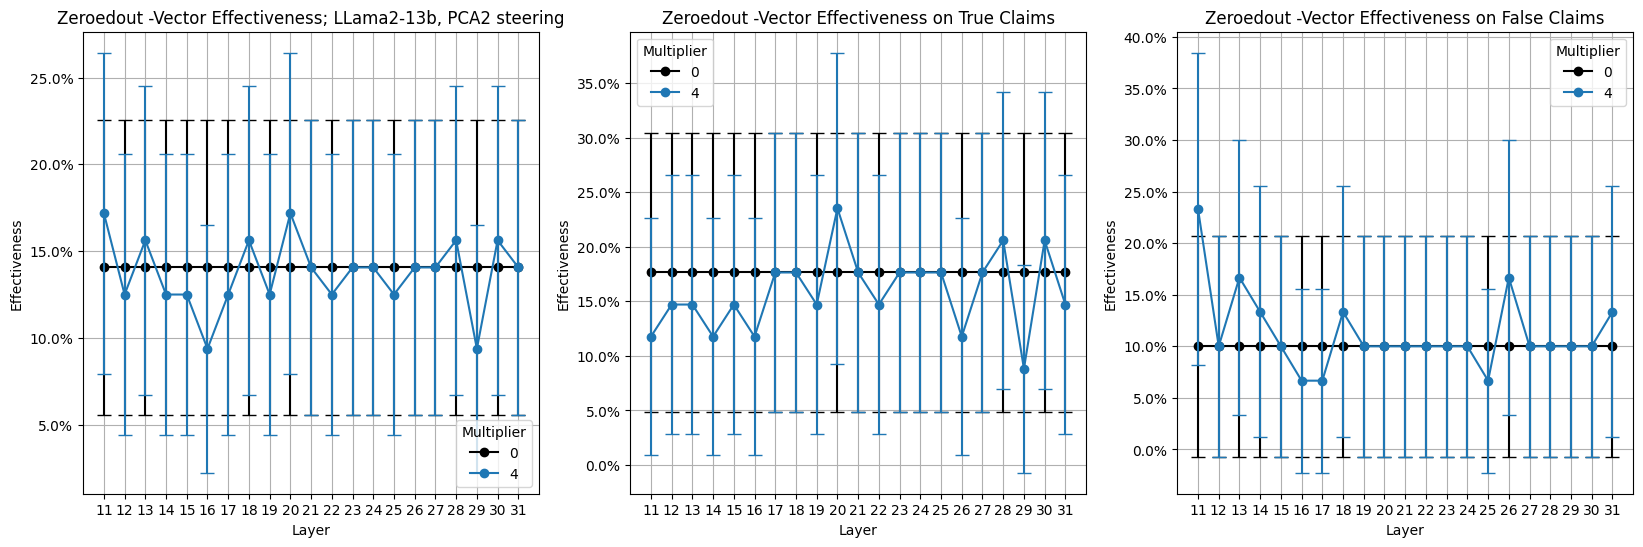

In [2]:
### Dumbly count up trues/falses/(A)s/(B)s by layer and mult
# Accuracy%
import json
import pandas as pd
import re
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter

outputdir = ""
# file = outputdir+"continuoussteer_norm_trainset_split_diff_llama2-13b.json"
file = outputdir+"continuoussteer_nonorm_gpt4facts_pca2diff_zeroout_llama2-7b.json"
###file = outputdir+"continuoussteer_nonorm_tqa_pca2diff_zeroout_llama2-13b.json"
###file = outputdir+"continuoussteer_norm_tqa_2afc_pca2_llama2-7b.json"
with open(file, 'r') as infile:
    resps = json.load(infile)

facts_df = pd.read_csv("data/gpt4_facts.csv") #eval

def get_sorted_layer_mult_combinations(data):
    if not data:
        return []
    
    # Extract keys from the first item's 'steered' dictionary
    keys = list(data[0]['steered'].keys())

    # Map each layer to its order of appearance
    layer_order = {}
    order = 0  # To track the order of appearance

    # Parse keys into tuples (order, layer, mult)
    parsed_keys = []
    for key in keys:
        layer_part = key.split('_')[0][5:]
        mult_part = int(key.split('_')[1][4:])
        
        if layer_part not in layer_order:
            layer_order[layer_part] = order
            order += 1

        parsed_keys.append((layer_order[layer_part], layer_part, mult_part))

    # Sort by appearance order stored in layer_order, then by mult
    parsed_keys.sort(key=lambda x: (x[0], x[2]))  # x[0] is order, x[2] is mult

    # Return keys in the original format but sorted
    sorted_keys = [f"layer{layer}_mult{str(mult).replace('.0', '')}" for _, layer, mult in parsed_keys]
    return sorted_keys

def evaluate_answer(text):
    """
    Returns:
        int: 1 if "true" or "(A)" appears before "false" or "(B)", -1 if the opposite is true, 0 if none are found.
    """
    true_pos = text.lower().find("true")
    false_pos = text.lower().find("false")
    a_pos = text.find("(A)")
    b_pos = text.find("(B)")
    correct_pos = text.lower().find("correct")
    nottrue_pos = text.lower().find("t true")
    notcorrect_pos = text.lower().find("t correct")

    true_positions = [pos for pos in [true_pos, a_pos, correct_pos] if pos != -1]
    false_positions = [pos for pos in [false_pos, b_pos, nottrue_pos, notcorrect_pos] if pos != -1]

    # Find the minimum valid positions, or set to float('inf') if none are found
    pos_true = min(true_positions) if true_positions else float('inf')
    pos_false = min(false_positions) if false_positions else float('inf')

    # Evaluate the positions and return the corresponding values
    if pos_true == float('inf') and pos_false == float('inf'):
        return 0  # None of the keywords are present
    elif pos_true < pos_false:
        return 1  # "true" or "(a)" appears before "false" or "(b)"
    else:
        return -1  # "false" or "(b)" appears before "true" or "(a)" or is the only one found

layer_mult_combinations = get_sorted_layer_mult_combinations(resps)
#get unique layers and mults from the keys
layers = list({key.split('_')[0][5:]: None for key in layer_mult_combinations}.keys())
mults = list(sorted(set(int(key.split('_')[1][4:]) for key in layer_mult_combinations)))

pos_effectiveness_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)
control_effectiveness_df = pd.DataFrame(0.0, index=layers, columns=mults)
neg_effectiveness_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)
pos_effectiveness_truths_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)
control_effectiveness_truths_df = pd.DataFrame(0.0, index=layers, columns=mults)
neg_effectiveness_truths_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)
pos_effectiveness_lies_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)
control_effectiveness_lies_df = pd.DataFrame(0.0, index=layers, columns=mults)
neg_effectiveness_lies_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)

zeroedout_pos_effectiveness_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)
zeroedout_neg_effectiveness_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)
zeroedout_pos_effectiveness_truths_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)
zeroedout_neg_effectiveness_truths_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)
zeroedout_pos_effectiveness_lies_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)
zeroedout_neg_effectiveness_lies_df = pd.DataFrame(0.0, index=layers, columns=[0]+mults)

for layermult in layer_mult_combinations:
    layer = layermult.split('_')[0][5:]
    mult = int(layermult.split('_')[1][4:])
    #print(f"Layer {layer}, Mult {mult}")

    sentctr=0
    truectr, falsectr = 0, 0
    for i, entry in enumerate(resps):
        sent = re.match(r"\[INST\]\sQuestion:\sIs\sthe\sfollowing\sclaim\strue\sor\sfalse\?\s(.*?)\n\nChoices.*",entry['sentence'],re.VERBOSE).group(1)
        true_label = int(facts_df[facts_df['statement']==sent]['label'].values[0])
###        true_label = 1 if i%2 == 0 else 0 #alternating whether A or B is the true one
        if true_label == 1:
            truectr += 1
            if evaluate_answer(entry['steered'][layermult]['answer_pos']) == 1: 
                pos_effectiveness_df.loc[layer, mult] += 1
                pos_effectiveness_truths_df.loc[layer, mult] += 1
            if evaluate_answer(entry['steered'][layermult]['answer_neg']) == -1: 
                neg_effectiveness_df.loc[layer, mult] += 1
                neg_effectiveness_truths_df.loc[layer, mult] += 1
            if evaluate_answer(entry['answer_neut']) == 1: 
                control_effectiveness_df.loc[layer, mult] += 1
                control_effectiveness_truths_df.loc[layer, mult] += 1
                pos_effectiveness_df.loc[layer, 0] += 1/len(mults)
                pos_effectiveness_truths_df.loc[layer, 0] += 1/len(mults)
                zeroedout_pos_effectiveness_df.loc[layer, 0] += 1/len(mults)
                zeroedout_pos_effectiveness_truths_df.loc[layer, 0] += 1/len(mults)
            elif evaluate_answer(entry['answer_neut']) == -1: 
                neg_effectiveness_df.loc[layer, 0] += 1/len(mults)
                neg_effectiveness_truths_df.loc[layer, 0] += 1/len(mults)
                zeroedout_neg_effectiveness_df.loc[layer, 0] += 1/len(mults)
                zeroedout_neg_effectiveness_truths_df.loc[layer, 0] += 1/len(mults)
            if evaluate_answer(entry['steered'][layermult]['answer_zeroedout_pos']) == 1: 
                zeroedout_pos_effectiveness_df.loc[layer, mult] += 1
                zeroedout_pos_effectiveness_truths_df.loc[layer, mult] += 1
            if evaluate_answer(entry['steered'][layermult]['answer_zeroedout_neg']) == -1: 
                zeroedout_neg_effectiveness_df.loc[layer, mult] += 1
                zeroedout_neg_effectiveness_truths_df.loc[layer, mult] += 1
        else:
            falsectr += 1
            if evaluate_answer(entry['steered'][layermult]['answer_pos']) == -1: 
                pos_effectiveness_df.loc[layer, mult] += 1
                pos_effectiveness_lies_df.loc[layer, mult] += 1
            if evaluate_answer(entry['steered'][layermult]['answer_neg']) == 1: 
                neg_effectiveness_df.loc[layer, mult] += 1
                neg_effectiveness_lies_df.loc[layer, mult] += 1
            if evaluate_answer(entry['answer_neut']) == -1: 
                control_effectiveness_df.loc[layer, mult] += 1
                control_effectiveness_lies_df.loc[layer, mult] += 1
                pos_effectiveness_df.loc[layer, 0] += 1/len(mults)
                pos_effectiveness_lies_df.loc[layer, 0] += 1/len(mults)
                zeroedout_pos_effectiveness_df.loc[layer, 0] += 1/len(mults)
                zeroedout_pos_effectiveness_lies_df.loc[layer, 0] += 1/len(mults)
            elif evaluate_answer(entry['answer_neut']) == 1: 
                neg_effectiveness_df.loc[layer, 0] += 1/len(mults)
                neg_effectiveness_lies_df.loc[layer, 0] += 1/len(mults)
                zeroedout_neg_effectiveness_df.loc[layer, 0] += 1/len(mults)
                zeroedout_neg_effectiveness_lies_df.loc[layer, 0] += 1/len(mults)
            if evaluate_answer(entry['steered'][layermult]['answer_zeroedout_pos']) == -1: 
                zeroedout_pos_effectiveness_df.loc[layer, mult] += 1
                zeroedout_pos_effectiveness_lies_df.loc[layer, mult] += 1
            if evaluate_answer(entry['steered'][layermult]['answer_zeroedout_neg']) == 1: 
                zeroedout_neg_effectiveness_df.loc[layer, mult] += 1
                zeroedout_neg_effectiveness_lies_df.loc[layer, mult] += 1
        sentctr += 1


def plot_effectiveness(ax, df, n, title):
#    df = treatment_effectiveness_df - control_effectiveness_df
#    point_estimates = df / n
#    SE = ((treatment_effectiveness_df + control_effectiveness_df) / n**2)**0.5
#    ci_95 = 1.96 * SE

    # Convert CIs back to counts
#    lower_bound = (point_estimates - ci_95) * n
#    upper_bound = (point_estimates + ci_95) * n

    proportions = df / n
    ci_95 = 1.96 * (proportions * (1 - proportions) / n)**0.5

    # Convert CIs back to counts
    lower_bound = (proportions - ci_95) * n
    upper_bound = (proportions + ci_95) * n

    df = proportions
    lower_bound = (proportions - ci_95)
    upper_bound = (proportions + ci_95)
    for mult in df.columns:
        color = 'black' if mult == 0 else None  # Let Matplotlib choose the color for the other lines
        line, = ax.plot(df.index, df[mult], marker='o', label=f'{mult}', color=color)
        ax.errorbar(df.index, df[mult],
                    yerr=[df[mult] - lower_bound[mult], upper_bound[mult] - df[mult]],
                    fmt='none', ecolor=line.get_color(), capsize=5, alpha=1.0)
    
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    ax.set_title(title)
    ax.set_xlabel('Layer')
    ax.set_ylabel("Effectiveness")
    ax.legend(title='Multiplier')
    ax.grid(True)


#pos_effectiveness_df = pos_effectiveness_df.drop('17,19')
#pos_effectiveness_truths_df = pos_effectiveness_truths_df.drop('17,19')
#pos_effectiveness_lies_df = pos_effectiveness_lies_df.drop('17,19')
#neg_effectiveness_df = neg_effectiveness_df.drop('17,19')
#neg_effectiveness_truths_df = neg_effectiveness_truths_df.drop('17,19')
#neg_effectiveness_lies_df = neg_effectiveness_lies_df.drop('17,19')

fig, axs = plt.subplots(1, 2, figsize=(20, 6)) 
plot_effectiveness(axs[0], pos_effectiveness_df, sentctr, "+Vector Effectiveness; LLama2-13b, PCA2 steering")
plot_effectiveness(axs[1], neg_effectiveness_df, sentctr, "-Vector Effectiveness; LLama2-13b, PCA2 steering")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(20, 6)) 
plot_effectiveness(axs[0], pos_effectiveness_truths_df, truectr, "+Vector Effectiveness on True Claims; LLama2-13b, PCA2 steering")
plot_effectiveness(axs[1], pos_effectiveness_lies_df, falsectr, "+Vector Effectiveness on False Claims; LLama2-13b, PCA2 steering")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(20, 6)) 
plot_effectiveness(axs[0], neg_effectiveness_truths_df, truectr, "-Vector Effectiveness on True Claims; LLama2-13b, PCA2 steering")
plot_effectiveness(axs[1], neg_effectiveness_lies_df, falsectr, "-Vector Effectiveness on False Claims; LLama2-13b, PCA2 steering")
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
plot_effectiveness(axs[0], zeroedout_pos_effectiveness_df.iloc[:, :2], sentctr, "Zeroedout +Vector Effectiveness; LLama2-13b, PCA2 steering")
plot_effectiveness(axs[1], zeroedout_pos_effectiveness_truths_df.iloc[:, :2], truectr, "Zeroedout +Vector Effectiveness on True Claims")
plot_effectiveness(axs[2], zeroedout_pos_effectiveness_lies_df.iloc[:, :2], falsectr, "Zeroedout +Vector Effectiveness on False Claims")
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
plot_effectiveness(axs[0], zeroedout_neg_effectiveness_df.iloc[:, :2], sentctr, "Zeroedout -Vector Effectiveness; LLama2-13b, PCA2 steering")
plot_effectiveness(axs[1], zeroedout_neg_effectiveness_truths_df.iloc[:, :2], truectr, "Zeroedout -Vector Effectiveness on True Claims")
plot_effectiveness(axs[2], zeroedout_neg_effectiveness_lies_df.iloc[:, :2], falsectr, "Zeroedout -Vector Effectiveness on False Claims")
plt.show()